In [1]:
import treelib as tl
import numpy as np
import random
import scipy.stats as stats

#define a number of nodes for the tree randomly
nodes = np.random.randint(2, 4)
#defines a number of mutations randomly
mutations = np.random.randint(10, 15)
#defines a mutation probability randomly
#mutation_ratio = np.random.uniform(0.2,0.3)
mutation_ratio = 0.1
initial_mutation_ratio = 0.1
#defines a number of cells randomly
base = np.random.randint(1, 3)




def generate_tree(nodes,mutations,mutation_ratio,initial_mutation_ratio,base,minimum_mutation_range=(0,1)):
    """"
    Generates a tree of mutation clusters with random nodes and mutations taking as input:

    nodes: Number of nodes in the tree (the number of clusters of the genetic tree)
    mutations: Number of mutations in the tree (the number of mutations in the genetic tree)
    mutation_ratio: A mutation ratio (to indicate how  possible is a mutation to happen in the initial root mutated parent cluster)
    initial_mutation_ratio: probability of mutation in the initial cluster
    base: number of cells in the initial cluster
    minimum_mutation_range: range of minimum mutations in a cluster

    And returns:
    
    main_tree: the CTC cluster lineages tree generated
    frequency_list: the mutation frequencies
    frequency_list_noisy: the mutation frequencies with noise
    cluster_list: the list of clusters with their corresponding mutations
    total: the total number of cells in the tree 
    
    """

    #cluster_list mutations utilizadas (se usa para mantener el teorema de los sitios infinitos) (ISA)))
    cluster_list_mutations = ""
    #total number of cells
    total = 0

    def mutate(parent,cluster_list_mutations):
        """"
        Creates a cluster_list of mutations and a name for a child cluster, taking the cluster of the parent node and generating new mutations, generates the first mutation and from there there is a possibility that another mutation will be generated from the mutation_ratio parameter, and for each new mutation this possibility is reduced more
        To avoid repeating mutations, the cluster_list of mutations that have already occurred is used to select a mutation at random that has not yet occurred
        The minimum_mutation_range parameter is used to indicate the minimum number of mutations that a cluster must have
        """
        p = mutation_ratio * 2
        min = np.random.randint(minimum_mutation_range[0], minimum_mutation_range[1])
        name = parent.identifier
        while True:
            #print("cluster_list_mutations", cluster_list_mutations)
            """generates a random mutation that has not yet happened"""
            n = random.choice([i for i, x in enumerate(cluster_list_mutations) if x == "0"])+1
            #print("n", n)
            if len(name) >= n:
                name = name[:n-1] + "1" + name[n:]
            else:
                name = name[:n-1] + "1"
            #print("name", name)
            #cluster_list_mutations = [ max(x,y) for x in name for y in cluster_list_mutations ]
            cluster_list_mutations = [ max(x, y) for (x,y) in zip(name,cluster_list_mutations) ]
            #print("cluster_list_mutations_modificada", cluster_list_mutations)

            min = min - 1
            #print("min", min)
            if min < 0:
                p = p/2
                if not np.random.choice([False,True], p=[1-p, p]):
                    break
        #cluster_list_mutations = ["1" if x == "1" else "0" for x,y in name,cluster_list_mutations]
        #name = "".join([np.random.choice(["0","1"], p=[mutation_ratio, 1-mutation_ratio]) if x == "0" else "1" for x in parent.identifier])
        #print("name", name)
        #print("cluster_list_mutations", cluster_list_mutations)
        #print("name", name)
        return name,cluster_list_mutations

    def get_population(base,level):
        return np.random.randint(base+level*2, base+1+level*5)


    """" The initial tree is created with the number of nodes """
    main_tree = tl.Tree()
    name = "".join(np.random.choice([0,1], p=[1-initial_mutation_ratio, initial_mutation_ratio], size=mutations).astype(str))
    cluster_list_mutations = name

    """The mutated parent node from which the other nodes will derive is generated"""
    n = random.choice([i for i, x in enumerate(cluster_list_mutations) if x == "0"])+1
    #print("n", n)
    if len(name) >= n:
        name = name[:n-1] + "1" + name[n:]
    else:
        name = name[:n-1] + "1"
    #print("name", name)
    #cluster_list_mutations = [ max(x,y) for x in name for y in cluster_list_mutations ]
    """The cluster_list of mutations is a variable that will be used to keep track of which mutations of the possible ones have happened in each cluster, in this way the infinite sites assumtion (ISA) can be maintained"""
    cluster_list_mutations = name

    #the number of cells of the initial mutated parent node is generated
    number = get_population(base,0)
    total = number
    main_tree.create_node(name+ "_" + str(number), name)


    def create_mutated_child(parent,mutation_ratio,cluster_list_mutations):
        """"
        Creates a mutated child node from a parent node and adds it to the tree, returns the number of cells of the child node and the cluster_list of mutations
        """
        #en un string de 0s y 1s, cambiar un numero de mutations al azar a 1s
        #name = "".join([np.random.choice(["0","1"], p=[mutation_ratio, 1-mutation_ratio]) if x == "0" else "1" for x in parent.identifier])
        name,cluster_list_mutations = mutate(parent,cluster_list_mutations)
        number = get_population(base,main_tree.level(parent.identifier )  + 1)
        #add the child to the tree
        #this check now should not be necessary as in the function mutate a correct valid name is always returned
        if main_tree.get_node(name) is None:
            main_tree.create_node(name+ "_" + str(number), name, parent=parent.identifier)
            return number,cluster_list_mutations
        else:
            return 0,cluster_list_mutations


    #choose a random node to mutate
    """
        A parent node from which the mutated child node will derive is chosen randomly, the process is repeated as many times as indicated in the nodes variable
    """
    for i in range(nodes):
        node = random.choice(main_tree.all_nodes())
        #print(node.tag)
        n,cluster_list_mutations = create_mutated_child(node,mutation_ratio,cluster_list_mutations)
        total += n

    """Finally generates a cluster_list with the mutations that have occurred in each cluster"""
    #main_tree.show()
    cluster_list = ([x.identifier for x in main_tree.all_nodes()])
    #print(cluster_list)
    cluster_list_imprimir = ([x.tag.split("_")[0] for x in main_tree.all_nodes()])
    numero_celulas = ([x.tag.split("_")[1] for x in main_tree.all_nodes()])
    #make a list of tuples with the mutations and the number of cells
    mix_list = [list(x) for x in zip(cluster_list_imprimir, numero_celulas)]
    #print(combined_list)
    #print(cluster_list_imprimir)
    #print(numero_celulas)

    def get_mutations_rates(tree_list):
        """
            Calculates the frequency of each mutation using the number of cells in each cluster and the total number of cells
        """
        number_clusters = len(tree_list)
        number_mutations = len(tree_list[0][0])
        mutation_rates = np.zeros(number_mutations)
        for tree in tree_list:
            mutation_rates += (np.array([int(x) for x in tree[0]])*int(tree[1]))
            #print(mutation_rates)
        mutation_rates = mutation_rates/total#len(tree_list)
        #print(mutation_rates)
        return mutation_rates

    def apply_noise(frequencies,bound,sigma=100,mu=0):
        """
            Adds noise to the mutation frequencies of each mutation following a truncated normal distribution
        """
        noise = stats.truncnorm( (-bound - mu) / sigma, (bound - mu) / sigma, loc=mu, scale=sigma).rvs(len(frequencies))

        #return frequencies + noise
        return np.where(frequencies>0,frequencies + noise,frequencies)

    #print(get_mutations_rates(cluster_list_imprimir))
    #print("total", total)
    #freq_list = get_mutations_rates(mix_list)
    #combined_list = [list(x) for x in zip(cluster_list_imprimir, freq_list)]
    #return main_tree,freq_list,cluster_list,total,combined_list
    frequency_list = get_mutations_rates(mix_list)
    frequency_list_noisy = apply_noise(frequency_list,(1/total/2))
        
    return main_tree,frequency_list,frequency_list_noisy,cluster_list,total

#main_tree,frequencies,cluster_list,total,combined_list = generate_tree(nodes,mutations,mutation_ratio,initial_mutation_ratio,base)
#noise = True
main_tree,frequencies,noiser_frequencies,cluster_list,total = generate_tree(nodes,mutations,mutation_ratio,initial_mutation_ratio,base)
main_tree.show()
print("frequencies", frequencies)


1000000000_2
└── 1000100000_6
    └── 1000100011_7
        └── 1000100111_11

frequencies [1.         0.         0.         0.         0.92307692 0.
 0.         0.42307692 0.69230769 0.69230769]


In [3]:
#defines a random number of nodes in the tree
nodes = np.random.randint(2, 4)
#and a random number of mutations
mutations = np.random.randint(20, 21)
#and a random mutation probability
#mutation_ratio = np.random.uniform(0.2,0.3)
mutation_ratio = 0.1
initial_mutation_ratio = 0.1
#random number of cells
base = np.random.randint(1, 3)

ruido = True


#arbol,frecuencias,lista,total,combined_list = generate_tree(nodos,mutaciones,mutation_ratio,initial_mutation_ratio,base)
#arbol,frecuencias,frecuencias_ruido,lista,total = generate_tree(nodos,mutaciones,mutation_ratio,initial_mutation_ratio,base)
tree,frequencies,frequencies_noise,cluster_list,total = generate_tree(nodes,mutations,mutation_ratio,initial_mutation_ratio,base)
print("tree\n", tree)
print("frequencies\n", frequencies)
print("frequencies_noise\n", frequencies_noise)
print("cluster_list\n", cluster_list)
print("total\n", total)
#print("combined_list", combined_list)


tree
 00000000000100000000_1
└── 00100000000100000000_4
    └── 00100000100100000000_10

frequencies
 [0.         0.         0.93333333 0.         0.         0.
 0.         0.         0.66666667 0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
frequencies_noise
 [0.         0.         0.96496613 0.         0.         0.
 0.         0.         0.670504   0.         0.         0.98903531
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
cluster_list
 ['00000000000100000000', '00100000000100000000', '00100000100100000000']
total
 15


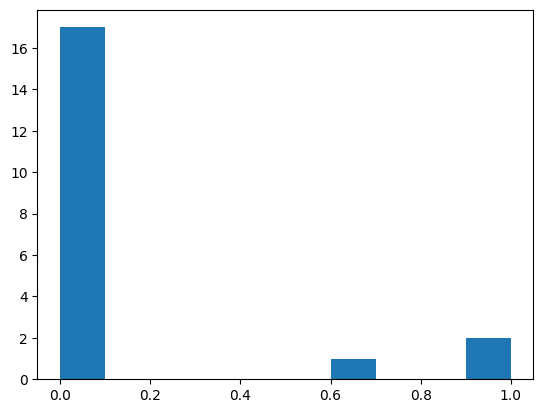

In [4]:
#make a histogram of the frequencies
import matplotlib.pyplot as plt
plt.hist(frequencies)
#for each different frequency of the list it stores the positions of the mutations that have that frequency
clusters = [frequencies]

# Frequencies without noise

## Algorithm 1: Decide a number of clusters from the total number of cells

In [5]:
def make_clusters(total,freq_list):
    """
    total: total number of cells
    combined_list: list of the frequency of each mutation in each cluster

    Takes the total number of cells and generates a cluster with the frequency assigned to according to the total number of cells
    So for example if we have 5 cells, 5 clusters can be generated with a frequency of 0.2, 0.4, 0.6, 0.8 and 1.0, since those are all the possible frequencies that can be generated with 5 cells (without counting the noise) (although that does not mean that all these clusters will be generated)
    """
    clusters = {}
    for i in range(total):
        #a dictionary is generated with an element that will be i/total
        clusters.update({(i+1)/total:[]})
    
    count = 0
    for i in freq_list:
        if i == 0:
            count += 1
            continue
        #each mutation is added to the cluster with the closest frequency
        clusters[min(clusters.keys(), key=lambda k: abs(k - i))].append(count)
        count += 1
    
    #empty clusters are removed
    for i in list(clusters):
        if clusters[i] == []:
            del clusters[i]

    return clusters

clusters = make_clusters(total,frequencies)
print("clusters", clusters)

clusters {0.6666666666666666: [8], 0.9333333333333333: [2], 1.0: [11]}


## Algorithm 2: Using K-means

c:\Users\jm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

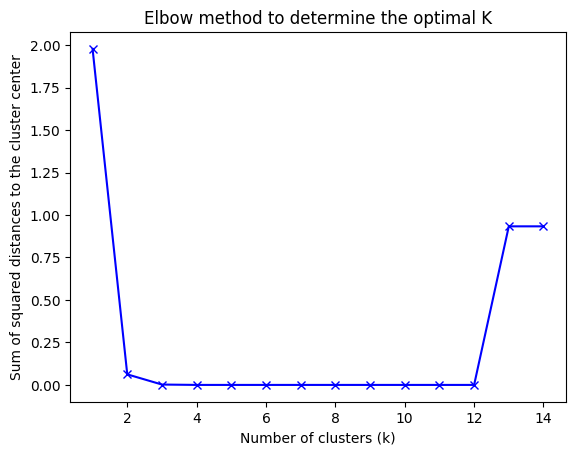

In [6]:
#elbow method can be used to choose the number of clusters

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

def elbow_method(frecuencias,total):

    #frequency_list of mutations
    l = frecuencias

    #transform the list into a numpy array
    X = np.array(l).reshape(-1, 1)

    #define an empty list to store the values of the sums of the squares within each cluster
    sum_of_squares = []

    #define the maximum number of clusters to try
    max_clusters = total

    # Try different values of k (number of clusters) and store the values of the sums of the squares within each cluster
    for k in range(1, max_clusters):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        sum_of_squares.append(kmeans.inertia_)

    # Plot an elbow graph to determine the optimal number of clusters
    plt.plot(range(1, max_clusters), sum_of_squares, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances to the cluster center')
    plt.title('Elbow method to determine the optimal K')
    plt.show()

elbow_method(frequencies,total)

In [13]:
#con kmeans
from sklearn.cluster import KMeans
import numpy as np
"""
#frequencies list of mutations
l = frequencies

# transform the list into a numpy array
X = np.array(l).reshape(-1, 1)

# Definir el número de clusters que deseas crear
n_clusters = 4

# Crear un objeto KMeans con el número de clusters especificado
kmeans = KMeans(n_clusters=n_clusters)

# Ejecutar el algoritmo K-means en los datos
kmeans.fit(X)

# Obtener las etiquetas de los clusters y los centroides
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Imprimir los resultados
print("Etiquetas de clusters:", labels)
print("Centroides:", centroids)
"""
#remove warnings
import warnings
warnings.filterwarnings("ignore")

def cluster_kmeans(frequencies, max_num_clusters):
    """
        Generates clusters with kmeans trying from 1 to max_num_clusters clusters
    """
    #transform the list into a numpy array
    X = np.array(frequencies).reshape(-1, 1)
    #define an empty list to store the values of the sums of the squares within each cluster
    sum_of_squares = []
    #define an inertia value of -1 to start with an impossible value of inertia
    inertia = -1
    #creates a dictionary to store the clusters
    clusters = []
    # Try different values of k (number of clusters) and store the values of the sums of the squares within each cluster
    for k in range(1, max_num_clusters):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        print("k:", k)
        print("Etiquetas de clusters:", labels)
        print("Centroides:", centroids)
        sum_of_squares.append(kmeans.inertia_)
        #add the clusters to the list
        clusters.append({"k":k,"labels":labels, "centroids":centroids, "inertia":kmeans.inertia_})
        #if the sum of the squares within the cluster does not improve, it stops, because it probably can't be improved anymore
        if inertia != -1 and kmeans.inertia_ > inertia:
            break
        inertia = kmeans.inertia_
    return clusters

    

clusters = cluster_kmeans(frequencies, total)

k: 1
Etiquetas de clusters: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Centroides: [[0.24]]
k: 2
Etiquetas de clusters: [0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1
 0 0 0]
Centroides: [[-1.66533454e-16]
 [ 8.72727273e-01]]
k: 3
Etiquetas de clusters: [0 0 2 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 1 1 0 0 1 1 0 0 1 0 1
 0 0 0]
Centroides: [[-1.66533454e-16]
 [ 9.52380952e-01]
 [ 7.33333333e-01]]
k: 4
Etiquetas de clusters: [1 1 2 2 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 3 0 1 1 0 0 1 1 0 1 3
 1 1 1]
Centroides: [[ 9.33333333e-01]
 [-1.66533454e-16]
 [ 7.33333333e-01]
 [ 1.00000000e+00]]
k: 5
Etiquetas de clusters: [4 4 2 2 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 2 4 4 3 1 4 4 1 1 4 4 1 4 3
 4 4 4]
Centroides: [[-1.38777878e-16]
 [ 9.33333333e-01]
 [ 7.33333333e-01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]]
k: 6
Etiquetas de clusters: [4 4 1 1 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 1 4 4 3 2 4 4 2 2 4 4 2 4 3
 4 

## Algorithm 3: Detecting the peaks of the histogram using KDE

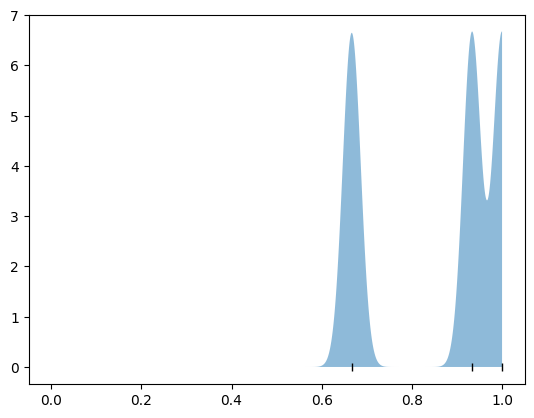

Minima: [0.79989995 0.96648324]
Maxima: [0.66683342 0.93346673 0.99949975]
********************************
[0.93333333 0.66666667 1.        ]
clusters {0.7998999499749875: [1], 0.9664832416208103: [0], 1: [2]}


In [8]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.signal import argrelextrema

def kde_cluster(total,freq_list,bandwidth=0.02,search_hyperparameters=False):

    #make 0 all the negative frequencies using list comprehension and 1 all the frequencies that are bigger than 1
    f = [0 if x < 0 else x for x in freq_list]
    f = [1 if x > 1 else x for x in f]
    #remove the 0s
    f = [x for x in f if x != 0]
    #f to ndarray
    f = np.array(f)
    f_d = np.linspace(0, 1, 2000)

    ###############################################
    #cross validation to find the best hyperparameters for the kernel and the bandwidth
    if search_hyperparameters:
        param_grid = {'kernel': ['gaussian', 'epanechnikov', 'exponential', 'linear'],
              'bandwidth' : np.linspace(0.005, 1, 10)
             }

        grid = GridSearchCV(
                estimator  = KernelDensity(),
                param_grid = param_grid,
                n_jobs     = -1,
                cv         = 10, 
                verbose    = 0
            )

        _ = grid.fit(X = f.reshape((-1,1)))

        print(grid.best_params_, ":", grid.best_score_, grid.scoring)

        kde = grid.best_estimator_

    ###############################################

    else:
        kde = KernelDensity(bandwidth=bandwidth, kernel="gaussian")
        kde.fit(f[:, None])


    # score_samples returns the log of the probability density
    logprob = kde.score_samples(f_d[:, None])
    plt.fill_between(f_d, np.exp(logprob), alpha=0.5)
    plt.plot(f, np.full_like(f, -0.01), '|k', markeredgewidth=1)
    #plt.ylim(-0.02, 0.22)
    plt.show()



    mi, ma = argrelextrema(logprob, np.less)[0], argrelextrema(logprob, np.greater)[0]

    print("Minima:", f_d[mi])
    print("Maxima:", f_d[ma])
    print("********************************")
    #print(f[f < f_d[mi][0]], f[(f >= f_d[mi][0]) * (f <= f_d[mi][1])], f[f >= f_d[mi][1]])
    #print(f[f < f_d[mi][0]], f[(f >= f_d[mi][0]) * (f < f_d[mi][1])], f[f >= f_d[mi][1]])
    print(f)


    f_d[mi]
    #a dictionary that stores clusters of mutations with the same frequency, where the key is the maximum frequency of the cluster
    clusters = {}
    for i in f_d[mi]:
        clusters.update({i:[]})
    clusters.update({1:[]})

    #the frequencies are added to the clusters, skipping the ones with frequency 0
    for i in range(len(f)):
        if f[i] != 0:
            for j in clusters.keys():
                if f[i] <= j:
                    clusters[j].append(i)
                    break

    return clusters

#frecuencias = [0.2,0.4,0.6,0.8,1.0]
clusters = kde_cluster(total,frequencies,bandwidth=0.02,search_hyperparameters=False)
print("clusters", clusters)

# Comparing with noise and without noise

In [16]:
#define a random number of nodes for the tree
nodes = np.random.randint(2, 5)
#and a random number of mutations
mutations = np.random.randint(40, 41)
#and a random mutation probability
#mutation_ratio = np.random.uniform(0.2,0.3)
mutation_ratio = 0.75
initial_mutation_ratio = 0.1
#random number of cells
base = np.random.randint(1, 3)


#arbol,frecuencias,lista,total,combined_list = generate_tree(nodos,mutaciones,mutation_ratio,initial_mutation_ratio,base)
#arbol,frecuencias,frecuencias_ruido,lista,total = generate_tree(nodos,mutaciones,mutation_ratio,initial_mutation_ratio,base,ruido,rango_mutaciones_minimo=(3,4))
tree, frequencies, frequencies_noise, mutation_list, total = generate_tree(nodes,mutations,mutation_ratio,initial_mutation_ratio,base,(3,4))
print("tree\n", tree)
print("frequencies\n", frequencies)
print("frequencies_noise\n", frequencies_noise)
print("mutation_list\n", mutation_list)
print("total\n", total)
#print("combined_list", combined_list)

tree
 0000000000000000000000000001000000000001_2
└── 0001000000000000000000100011010000000011_6
    └── 0011011001000000000000100111011000100011_10

frequencies
 [0.         0.         0.55555556 0.88888889 0.         0.55555556
 0.55555556 0.         0.         0.55555556 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.88888889 0.
 0.         0.55555556 0.88888889 1.         0.         0.88888889
 0.55555556 0.         0.         0.         0.55555556 0.
 0.         0.         0.88888889 1.        ]
frequencies_noise
 [0.         0.         0.54152708 0.89451643 0.         0.55064568
 0.54504409 0.         0.         0.53912406 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.87462548 0.
 0.         0.55783864 0.88158317 1.02469504 0.         0.90966292
 0.53004182 0.         0.         0.         0.5584586  0.
 0.         0.         0.86200115

In [18]:
#sin ruido
clusters = make_clusters(total,frequencies)
print("clusters without noise \t", clusters)

#con ruido
clusters = make_clusters(total,frequencies_noise)
print("clusters with noise \t", clusters)

clusters without noise 	 {0.5555555555555556: [2, 5, 6, 9, 25, 30, 34], 0.8888888888888888: [3, 22, 26, 29, 38], 1.0: [27, 39]}
clusters with noise 	 {0.5555555555555556: [2, 5, 6, 9, 25, 30, 34], 0.8888888888888888: [3, 22, 26, 29, 38], 1.0: [27, 39]}


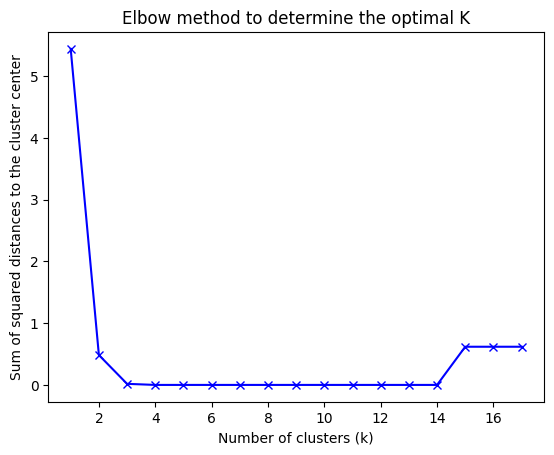

k: 1
Etiquetas de clusters: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Centroides: [[0.25833333]]
k: 2
Etiquetas de clusters: [0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0
 0 1 1]
Centroides: [[1.66533454e-16]
 [7.38095238e-01]]
k: 3
Etiquetas de clusters: [0 0 2 1 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 1 1 0 1 2 0 0 0 2 0 0
 0 1 1]
Centroides: [[1.66533454e-16]
 [9.20634921e-01]
 [5.55555556e-01]]
k: 4
Etiquetas de clusters: [1 1 2 3 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 2 3 0 1 3 2 1 1 1 2 1 1
 1 3 0]
Centroides: [[1.00000000e+00]
 [1.66533454e-16]
 [5.55555556e-01]
 [8.88888889e-01]]
k: 5
Etiquetas de clusters: [0 0 2 1 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 1 3 0 1 2 0 0 0 2 0 0
 0 1 3]
Centroides: [[1.66533454e-16]
 [8.88888889e-01]
 [5.55555556e-01]
 [1.00000000e+00]
 [0.00000000e+00]]
k: 6
Etiquetas de clusters: [0 0 2 1 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 1 3 0 1 2 0 0 0 2 0 0
 0 1 3]
Cen

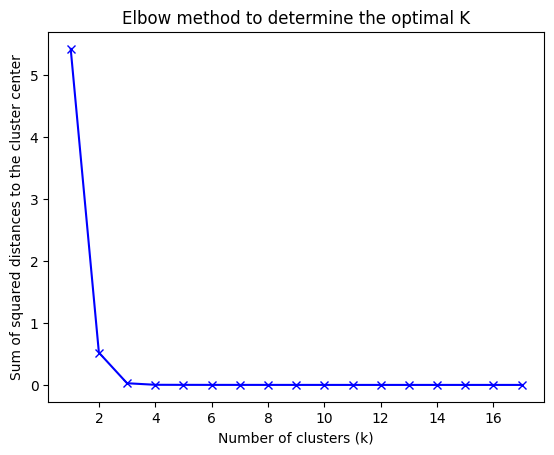

k: 1
Etiquetas de clusters: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Centroides: [[0.25697278]]
k: 2
Etiquetas de clusters: [1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1
 1 0 0]
Centroides: [[ 7.34207934e-01]
 [-1.11022302e-16]]
k: 3
Etiquetas de clusters: [0 0 2 1 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 1 1 0 1 2 0 0 0 2 0 0
 0 1 1]
Centroides: [[-1.11022302e-16]
 [ 9.22318730e-01]
 [ 5.46097139e-01]]
k: 4
Etiquetas de clusters: [1 1 2 0 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 2 0 3 1 0 2 1 1 1 2 1 1
 1 0 3]
Centroides: [[ 8.84477830e-01]
 [-1.11022302e-16]
 [ 5.46097139e-01]
 [ 1.01692098e+00]]
k: 5
Etiquetas de clusters: [0 0 2 1 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 2 4 3 0 1 2 0 0 0 2 0 0
 0 4 3]
Centroides: [[-1.11022302e-16]
 [ 9.02089676e-01]
 [ 5.46097139e-01]
 [ 1.01692098e+00]
 [ 8.72736600e-01]]
k: 6
Etiquetas de clusters: [1 1 0 4 1 5 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 5 2 3 1 4 0 1 1 1 5 1

In [19]:
#sin ruido
elbow_method(frequencies,total)
clusters = cluster_kmeans(frequencies, total)
print("clusters without noise \t", clusters)

#con ruido
elbow_method(frequencies_noise,total)
clusters = cluster_kmeans(frequencies_noise, total)
print("clusters with noise \t", clusters)

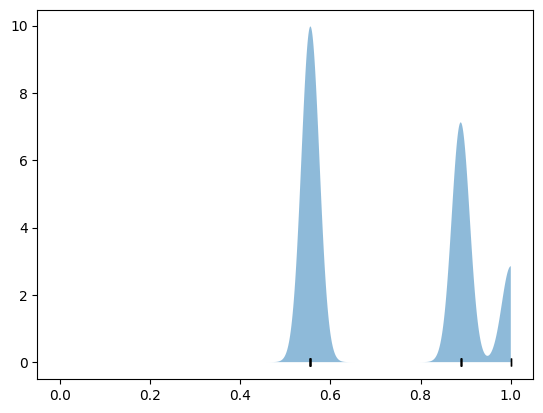

Minima: [0.72286143 0.94847424]
Maxima: [0.55577789 0.88894447]
********************************
[0.55555556 0.88888889 0.55555556 0.55555556 0.55555556 0.88888889
 0.55555556 0.88888889 1.         0.88888889 0.55555556 0.55555556
 0.88888889 1.        ]
clusters {0.7228614307153576: [0, 2, 3, 4, 6, 10, 11], 0.9484742371185592: [1, 5, 7, 9, 12], 1: [8, 13]}
{'bandwidth': 0.005, 'kernel': 'linear'} : 5.801663876520721 None


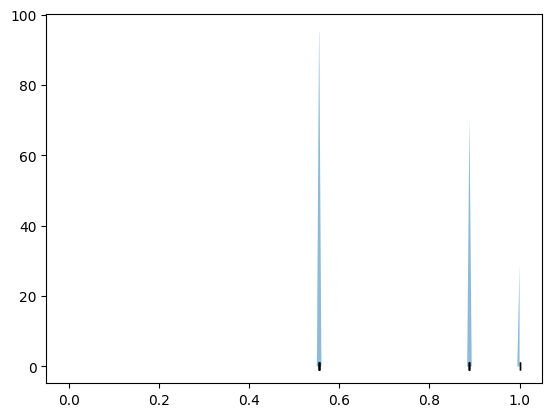

Minima: []
Maxima: [0.55577789 0.88894447]
********************************
[0.55555556 0.88888889 0.55555556 0.55555556 0.55555556 0.88888889
 0.55555556 0.88888889 1.         0.88888889 0.55555556 0.55555556
 0.88888889 1.        ]
clusters {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}


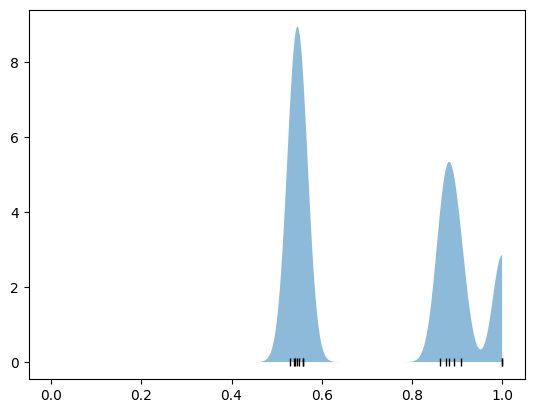

Minima: [0.71085543 0.95197599]
Maxima: [0.54627314 0.88294147]
********************************
[0.54152708 0.89451643 0.55064568 0.54504409 0.53912406 0.87462548
 0.55783864 0.88158317 1.         0.90966292 0.53004182 0.5584586
 0.86200115 1.        ]
clusters {0.7108554277138569: [0, 2, 3, 4, 6, 10, 11], 0.951975987993997: [1, 5, 7, 9, 12], 1: [8, 13]}
{'bandwidth': 0.005, 'kernel': 'exponential'} : 1.952288042561576 None


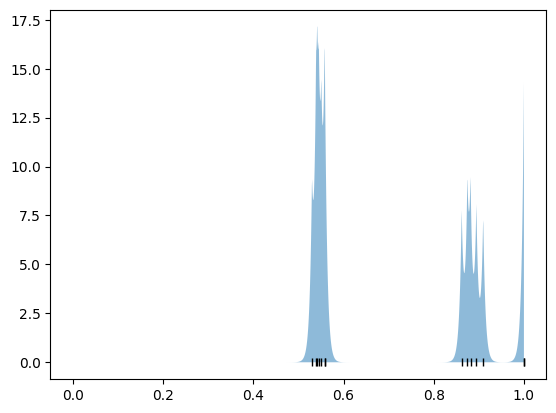

Minima: [0.53276638 0.54377189 0.54827414 0.55377689 0.71185593 0.86793397
 0.87793897 0.88844422 0.90245123 0.95347674]
Maxima: [0.53026513 0.54177089 0.54477239 0.55077539 0.55777889 0.86193097
 0.87443722 0.88144072 0.89444722 0.90945473]
********************************
[0.54152708 0.89451643 0.55064568 0.54504409 0.53912406 0.87462548
 0.55783864 0.88158317 1.         0.90966292 0.53004182 0.5584586
 0.86200115 1.        ]
clusters {0.5327663831915957: [10], 0.5437718859429714: [0, 4], 0.5482741370685342: [3], 0.5537768884442221: [2], 0.7118559279639819: [6, 11], 0.8679339669834917: [12], 0.8779389694847423: [5], 0.8884442221110554: [7], 0.9024512256128063: [1], 0.9534767383691846: [9], 1: [8, 13]}


In [17]:
#sin ruido
clusters = kde_cluster(total,frequencies,bandwidth=0.02,search_hyperparameters=False)
print("clusters", clusters)

clusters = kde_cluster(total,frequencies,bandwidth=0.02,search_hyperparameters=True)
print("clusters", clusters)

#con ruido
clusters = kde_cluster(total,frequencies_noise,bandwidth=0.02,search_hyperparameters=False)
print("clusters", clusters)

clusters = kde_cluster(total,frequencies_noise,bandwidth=0.02,search_hyperparameters=True)
print("clusters", clusters)


# Generating trees from frequencies

In [20]:


def build_genetic_trees(freqs):
    #a tree list is created
    trees = []
    #the initial tree is created with a frequency of 1
    arbol = tl.Tree()
    arbol.create_node(tag="0",identifier="0",data={"frecuencia": 1.0})

    #the initial tree is added to the tree list
    trees.append(arbol)

    #for each frequency in the frequency list the following is done
    while True:
        #the most frequent node is taken
        max_freq_idx = freqs.index(max(freqs))+1
        #max_freq_idx = freqs[np.where(freqs == max(freqs))][0]
        max_freq = freqs[max_freq_idx-1]
        #is removed from the frequency list
        freqs[max_freq_idx-1] = 0.0 
        if max_freq == 0.0:
            break
        #an auxiliary L1 list is created that will later replace the list of trees
        L1 = []
        #for each tree in the tree list the following is done
        for tree in trees:
            #print(tree)
            #for each node in the tree the following is done
            for node in tree.all_nodes():
                #if the node has a frequency greater than zero
                if node.data["frecuencia"] >= max_freq:
                    #print("node freq", node.data["frecuencia"], "max_freq", max_freq)
                    #a tree copy is created
                    tree_copy = tl.Tree(tree.subtree(tree.root), deep=True)
                    
                    #a node is created with the frequency of the most frequent node taken before
                    tree_copy.create_node(tag=str(max_freq_idx)+"_"+str(max_freq),identifier=str(max_freq_idx)+"_"+str(max_freq),data={"frecuencia": max_freq},parent=node.identifier)
                    #print("tree_copy", tree_copy)
                    #print("tree", tree)
                    #the frequency of the node is updated
                    new_node = tree_copy.get_node(node.identifier)
                    new_node.data["frecuencia"] = new_node.data["frecuencia"] - max_freq
                    #print("new_node", new_node)
                    #the tree is added to the auxiliary list
                    L1.append(tree_copy)
        #the tree list is replaced by the auxiliary list
        for tree in L1:
            print(tree)
        #    for node in tree.all_nodes():
                #print(node)
        print("***********************")
        trees = L1
        
    return trees


f = [1,0.65,0.2,0.25,0.25]
trees = build_genetic_trees(f)
for tree in trees:
    print(tree)

#trees = build_genetic_trees(frecuencias.tolist())
#for tree in trees:
#    print(tree)


0
└── 1_1

***********************
0
└── 1_1
    └── 2_0.65

***********************
0
└── 1_1
    ├── 2_0.65
    └── 4_0.25

0
└── 1_1
    └── 2_0.65
        └── 4_0.25

***********************
0
└── 1_1
    ├── 2_0.65
    │   └── 5_0.25
    └── 4_0.25

0
└── 1_1
    ├── 2_0.65
    └── 4_0.25
        └── 5_0.25

0
└── 1_1
    ├── 2_0.65
    │   └── 4_0.25
    └── 5_0.25

0
└── 1_1
    └── 2_0.65
        ├── 4_0.25
        └── 5_0.25

0
└── 1_1
    └── 2_0.65
        └── 4_0.25
            └── 5_0.25

***********************
0
└── 1_1
    ├── 2_0.65
    │   ├── 3_0.2
    │   └── 5_0.25
    └── 4_0.25

0
└── 1_1
    ├── 2_0.65
    │   └── 5_0.25
    └── 4_0.25
        └── 3_0.2

0
└── 1_1
    ├── 2_0.65
    │   └── 5_0.25
    │       └── 3_0.2
    └── 4_0.25

0
└── 1_1
    ├── 2_0.65
    │   └── 3_0.2
    └── 4_0.25
        └── 5_0.25

0
└── 1_1
    ├── 2_0.65
    └── 4_0.25
        └── 5_0.25
            └── 3_0.2

0
└── 1_1
    ├── 2_0.65
    │   ├── 3_0.2
    │   └── 4_0.25
    └── 5

In [24]:
f = [1,0.65,0.2,0.25,0.25]
f = [1,0.75,0.5,0.25]
trees = build_genetic_trees(f)
for tree in trees:
    print(tree)
    

0
└── 1_1

***********************
0
└── 1_1
    └── 2_0.75

***********************
0
└── 1_1
    └── 2_0.75
        └── 3_0.5

***********************
0
└── 1_1
    ├── 2_0.75
    │   └── 3_0.5
    └── 4_0.25

0
└── 1_1
    └── 2_0.75
        ├── 3_0.5
        └── 4_0.25

0
└── 1_1
    └── 2_0.75
        └── 3_0.5
            └── 4_0.25

***********************
0
└── 1_1
    ├── 2_0.75
    │   └── 3_0.5
    └── 4_0.25

0
└── 1_1
    └── 2_0.75
        ├── 3_0.5
        └── 4_0.25

0
└── 1_1
    └── 2_0.75
        └── 3_0.5
            └── 4_0.25

